downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v001.jpg
downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v005.jpg


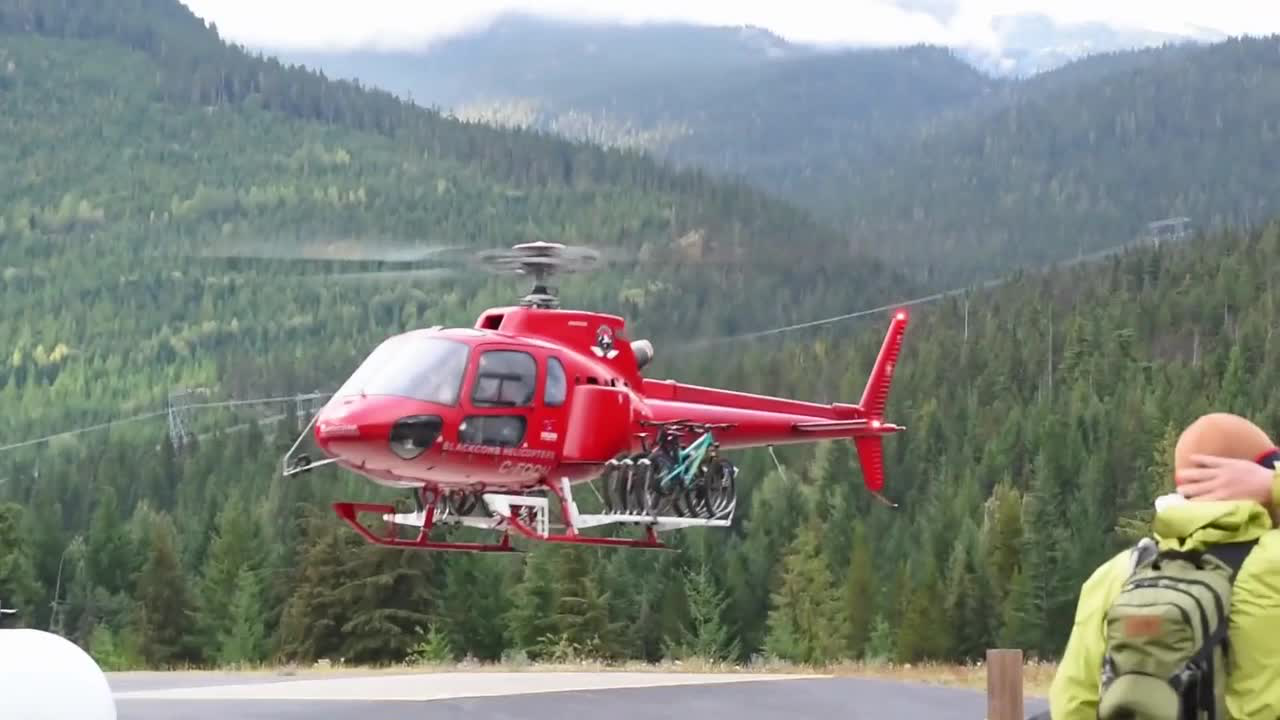

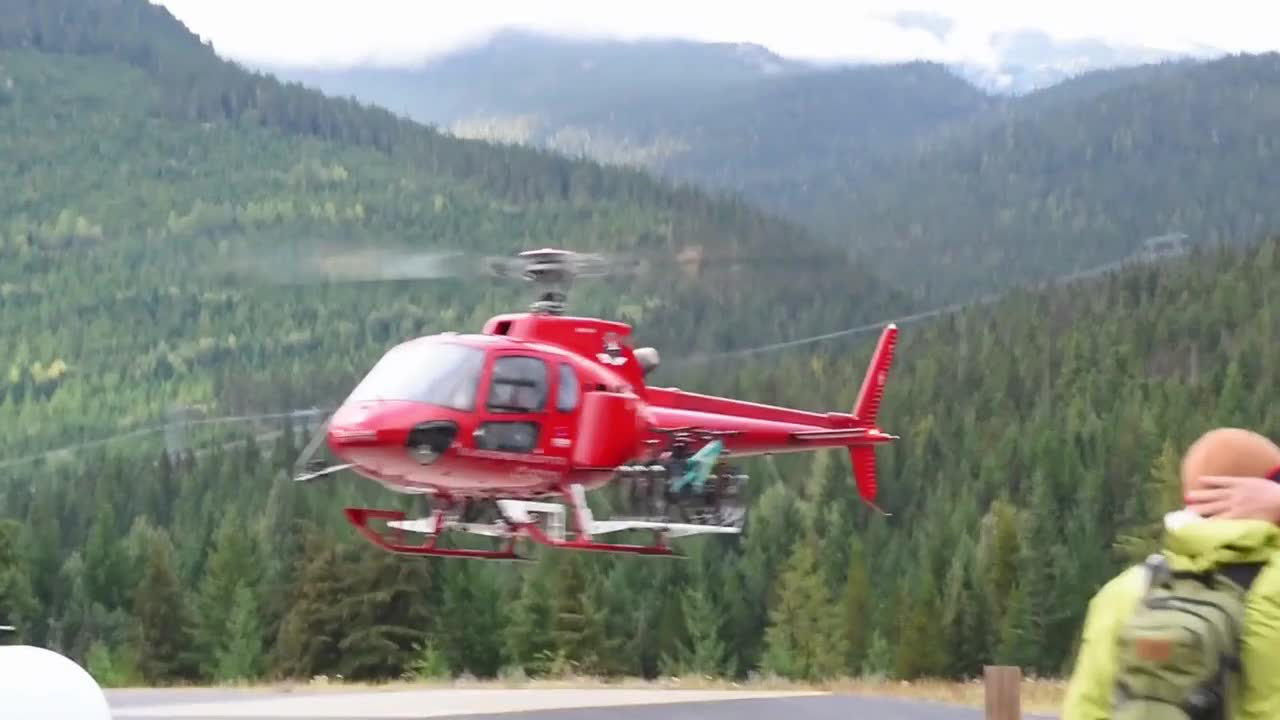

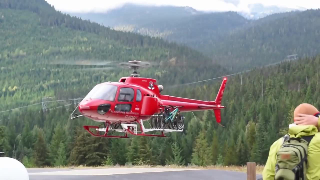

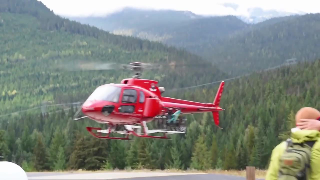

In [0]:
import numpy as np
import cv2
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

def url_to_image(url):
  print("downloading %s" % (url))
  return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)

url = "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v001.jpg"
img1 = url_to_image(url)

url = "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v005.jpg"
img2 = url_to_image(url)

cv2_imshow(img1)
cv2_imshow(img2)

img1 = cv2.resize(img1, dsize=((int(img1.shape[1] / 4), int(img1.shape[0] / 4))))
img2 = cv2.resize(img2, dsize=((int(img2.shape[1] / 4), int(img2.shape[0] / 4))))

# img1 = resize(img1, (img1.shape[0] / 4, img1.shape[1] / 4, 3),
#                        anti_aliasing=False)

# img2 = resize(img2, (img2.shape[0] / 4, img2.shape[1] / 4, 3),
#                        anti_aliasing=False,)

cv2_imshow(img1)
cv2_imshow(img2)

In [0]:
img1.shape

(180, 320, 3)

180 320 180 320
ITER:  1
ITER:  2
ITER:  3
ITER:  4
ITER:  5
[[(163, 137) (163, 137) (163, 137) ... (170, 161) (169, 158) (117, 215)]
 [(113, 227) (163, 137) (164, 137) ... (171, 161) (171, 161) (171, 161)]
 [(113, 227) (163, 137) (165, 136) ... (172, 161) (172, 161) (172, 161)]
 ...
 [(21, 69) (11, 51) (18, 257) ... (162, 316) (173, 299) (173, 299)]
 [(21, 69) (11, 51) (108, 86) ... (175, 300) (174, 299) (174, 300)]
 [(34, 312) (11, 51) (108, 86) ... (175, 300) (176, 300) (176, 301)]]


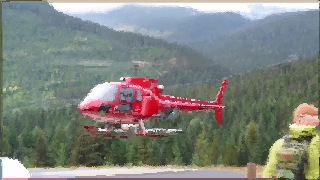

In [0]:
def init(A, B, patch_size):
  half = patch_size // 2
  B_h = B.shape[0]
  B_w = B.shape[1]
  A_h = A.shape[0]
  A_w = A.shape[1]
  
  x_offset = np.random.randint(half, B_h-half, (A_h,A_w))
  y_offset = np.random.randint(half, B_w-half, (A_h,A_w))
  
  F = np.zeros_like(A[:,:,0], dtype=object)
  for i in range(A_h):
    for j in range(A_w):
      F[i, j] = (x_offset[i,j], y_offset[i,j])
      
  return F


def get_bounding_box(pix, img, patch_size):
  tl = 0
  tr = 0
  bl = 0
  br = 0
  
  half = patch_size // 2
  
  if pix[0] - half < 0:
    tl = pix[0]
  else:
    tl = pix[0] - half
    
  if pix[0] + half >= img.shape[0]:
    tr = pix[0] + 1
  else:
    tr = pix[0] + half + 1
    
  if pix[1] - half < 0:
    bl = pix[1]
  else:
    bl = pix[1] - half
  
  if pix[1] + half >= img.shape[1]:
    br = pix[1] + 1
  else:
    br = pix[1] + half + 1
    
  print((tl, tr, bl, br))
  return (tl, tr, bl, br)

def dist(pix_a, pix_b, A, B, patch_size):
  half = patch_size // 2
#   print("pix a ", pix_a)
#   print("pix b ", pix_b)
  
  patch_A = A[pix_a[0]:pix_a[0]+patch_size, pix_a[1]:pix_a[1]+patch_size, :]
  patch_B = B[pix_b[0]-half:pix_b[0]+half+1, pix_b[1]-half:pix_b[1]+half+1, :]
  
#   print("patch A ", patch_A)
#   print(patch_A.shape)
#   print("patch B ", patch_B)
#   print(patch_B.shape)
  
  diff = patch_A - patch_B
  
  return np.sum(diff ** 2) / (patch_size ** 2)
  

def patch_match(A, B, patch_size, num_iter):
  F = init(A, B, patch_size)
  B_h = B.shape[0]
  B_w = B.shape[1]
  A_h = A.shape[0]
  A_w = A.shape[1]
  
  half = patch_size // 2
  A_p = np.zeros((A_h + half * 2, A_w + half * 2, 3))
  A_p[half:A_h+half, half:A_w+half,:] = A
  print(A_h, A_w, B_h, B_w)
  
  for it in range(1, num_iter + 1):
    print("ITER: ", it)
    if it % 2 == 0:
      for i in range(A_h-2, -1, -1):
        for j in range(A_w-2, -1, -1):
          
          #propagation
          dist_right = dist((i, min(j + 1,A_w-1)), F[i, min(j+1, A_w-1)], A_p, B, patch_size)
          dist_down = dist((min(i+1, A_h-1), j), F[min(i+1, A_h-1), j], A_p, B, patch_size)
          dist_curr = dist((i, j), F[i, j], A_p, B, patch_size)
          best_dist = dist_curr
          
          argmin = np.argmin(np.array([dist_curr, dist_right, dist_down]))
          
          if argmin == 1:
            F[i, j] = F[i, min(j + 1, A_w-1)]
            best_dist = dist_right
          if argmin == 2:
            F[i, j] = F[min(i+1,A_h-1), j]
            best_dist = dist_down
            
            
          #random search
          alpha = 0.5
          w = max(B_h, B_w)
          p = 4
          while w * alpha ** p > 1:
            R_x = np.random.uniform(-1, 1)
            R_y = np.random.uniform(-1, 1)
            
            x, y = F[i, j]
            x_new = int(np.rint(x + w * alpha ** p * R_x))
            y_new = int(np.rint(y + w * alpha ** p * R_y))
            
            x_new = min(max(half, x_new), B_h-half-1)
            y_new = min(max(half, y_new), B_w-half-1)
#             print(x_new, y_new)
#             dist_new = dist((x_new, y_new), F[i, j], A_p, B, patch_size)
            dist_new = dist((i,j), (x_new, y_new), A_p, B, patch_size)
            
            if  dist_new < best_dist:
              F[i, j] = (x_new, y_new)
              best_dist = dist_new
              
            p += 1
          
    else:
      for i in range(1, A_h):
        for j in range(1, A_w):
            
          #propagation
          dist_left = dist((i, max(j - 1,0)), F[i,max(j-1,0)], A_p, B, patch_size)
          dist_upper = dist((max(i - 1,0), j), F[max(i-1,0),j], A_p, B, patch_size)
          dist_curr = dist((i, j), F[i,j], A_p, B, patch_size)
          
          best_dist = dist_curr
          
          argmin = np.argmin(np.array([dist_curr, dist_left, dist_upper]))
          
          if argmin == 1:
            F[i, j] = F[i, max(j - 1,0)]
            best_dist = dist_left
          if argmin == 2:
            F[i, j] = F[max(i - 1,0), j]
            best_dist = dist_upper
            
            
          #random search
          alpha = 0.5
          w = max(B_h, B_w)
          p = 4
          while w * alpha ** p > 1:
            R_x = np.random.uniform(-1, 1)
            R_y = np.random.uniform(-1, 1)
            
            x, y = F[i, j]
            x_new = int(np.rint(x + w * alpha ** p * R_x))
            y_new = int(np.rint(y + w * alpha ** p * R_y))
            
            x_new = min(max(half, x_new), B_h-half-1)
            y_new = min(max(half, y_new), B_w-half-1)
#             print(x_new, y_new)
#             dist_new = dist((x_new, y_new), F[i, j], A_p, B, patch_size)
            dist_new = dist((i,j), (x_new, y_new), A_p, B, patch_size)
            
            if  dist_new < best_dist:
              F[i, j] = (x_new, y_new)
              best_dist = dist_new
              
            p += 1
            
  return F
          

F = patch_match(img1, img2, 7, 5)
recon = np.zeros_like(img1)

print(F)

for i in range(img1.shape[0]):
  for j in range(img1.shape[1]):
    recon[i, j, :] = img2[F[i, j][0], F[i, j][1], :]
    
cv2_imshow(recon)